In [1]:
import os, sys, pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder, get_flow_params

import gym, ray
from ray.rllib.agents.ppo import PPOAgent, DEFAULT_CONFIG
from ray.rllib.agents.ddpg import DDPGAgent, DEFAULT_CONFIG
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print

benchmark_name = 'multi_merge'
exp_name = 'fixed_bugs'
results_list = os.listdir('/headless/ray_results/' + exp_name)
AGENT = 'PPO' # 'PPO' or 'DDPG' or 'HUMAN'
checkpoint = '200'
num_cpus = 60
num_trials = 50

benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.buffered_obs_flow_params

ray.init(num_cpus=num_cpus, include_webui=False, ignore_reinit_error=True)

Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-23_20-43-18_61878/logs.
Waiting for redis server at 127.0.0.1:22279 to respond...
Waiting for redis server at 127.0.0.1:10461 to respond...
Starting the Plasma object store with 20.0 GB memory using /dev/shm.


{'node_ip_address': '10.138.0.2',
 'object_store_addresses': ['/tmp/ray/session_2019-05-23_20-43-18_61878/sockets/plasma_store'],
 'raylet_socket_names': ['/tmp/ray/session_2019-05-23_20-43-18_61878/sockets/raylet'],
 'redis_address': '10.138.0.2:22279',
 'webui_url': ''}

In [2]:
PPO_PATH = 'PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_[eta1, eta2, eta3]:[1.0, 0.1, 0.0]_t_min:10.0_buf_len: 3_4_2019-05-23_07-49-44t8z6ixz_'

In [3]:
PATH = ''
if AGENT == 'PPO':
    PATH = exp_name + '/' + PPO_PATH
    
if AGENT == 'DDPG':
    PATH = exp_name + '/' + DDPG_PATH
    
config_path = '/headless/rl_project/ray_results/' + PATH + '/params.pkl'
checkpoint_path = '/headless/rl_project/ray_results/' + PATH + '/checkpoint_{}/checkpoint-{}'.format(checkpoint, checkpoint)

with open(config_path, mode='rb') as f:
    config = pickle.load(f)
flow_params = get_flow_params(config)
create_env, env_name = make_create_env(params=flow_params, version=0)
env = create_env()
left_length = env.k.scenario.edge_length('left')
car_length = 5.0
scale = 10

# Register as rllib env
register_env(env_name, create_env)

 Starting SUMO on port 53663


In [4]:
@ray.remote
def evaluate(create_env, AGENT, config=None, env_name=None, checkpoint_path=None):
    agent = None
    if AGENT == 'PPO':
        agent = PPOAgent(config=config, env=env_name)
        agent.restore(checkpoint_path)
        
    env = create_env()
    
    left_length = env.k.scenario.edge_length('left')
    car_length = 5.0
    scale = 10
    
    # test until horizon
    state = env.reset()
    vel = []
    outflow = []
    for i in range(env.env_params.horizon):
        # record the mean velocity
        v = np.mean(env.k.vehicle.get_speed(env.k.vehicle.get_ids()))
        vel.append(v)

        # record the velocity map
        ids = env.k.vehicle.get_ids()
        vel_map_ = np.zeros(int(left_length)*scale)
        for id_ in ids:
            pos_ = np.round(env.k.vehicle.get_position(id_), decimals=1)
            vel_ = env.k.vehicle.get_speed(id_)
            pos_bottom = max(0, int((pos_-car_length/2.0)*scale))
            pos_top = min(int(left_length)*scale, int((pos_+car_length/2.0)*scale))
            if env.k.vehicle.get_edge(id_) == 'left':
                vel_map_[pos_bottom:pos_top] = vel_            

        # step the simulation
        rl_ids = env.k.vehicle.get_rl_ids()
        actions = {}
        if AGENT != 'HUMAN':
            for id_ in rl_ids:
                action = agent.compute_action(state[id_])
                actions.update({id_: action})
        state, r, _, _ = env.step(actions)
        outflow.append(env.k.vehicle.get_outflow_rate(100)) # measured by one min

        if i == 0:
            vel_map_list = vel_map_
        else:
            vel_map_list = np.vstack((vel_map_list, vel_map_))

    outflow = outflow[-500:]
    vel_map_list[vel_map_list==0.0] = np.nan

    return vel, outflow, vel_map_list

In [5]:
%%time
results = ray.get([evaluate.remote(create_env, AGENT, config, env_name, checkpoint_path) for _ in range(num_trials)])

CPU times: user 1.53 s, sys: 35.2 ms, total: 1.56 s
Wall time: 1min 38s


In [6]:
vel_list = []
outflow_list = []
vel_map_lists = []
for vel, outflow, vel_map_list in results:
    vel_list.append(vel)
    outflow_list.append(outflow)
    vel_map_lists.append(vel_map_list)
vel_mean = np.mean(vel_list, axis=0)
outflow_mean = np.mean(outflow_list, axis=0)
vel_map_mean = np.nanmean(vel_map_lists, axis=0)      

/opt/conda/envs/flow/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


In [7]:
np.save('trained_'+str(num_trials)+'_vel.npy', vel_mean)
np.save('trained_'+str(num_trials)+'_outflow.npy', outflow_mean)
np.save('trained_'+str(num_trials)+'_vel_map.npy', vel_map_mean)

human_vel_mean = np.load('human_'+str(num_trials)+'_vel.npy')
human_outflow_mean = np.load('human_'+str(num_trials)+'_outflow.npy')
human_vel_map_mean = np.load('human_'+str(num_trials)+'_vel_map.npy')

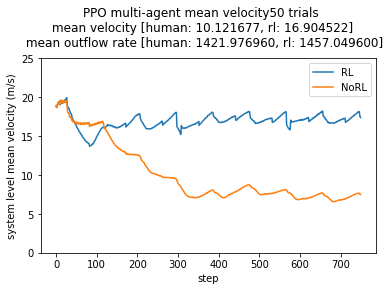

In [8]:
vel_fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(vel_mean)
ax.plot(human_vel_mean)
title = AGENT + ' multi-agent mean velocity'+str(num_trials)+' trials'
title = title + ' \n mean velocity [human: {:3f}, rl: {:3f}]'.format(np.mean(human_vel_mean), np.mean(vel_mean))
title = title + ' \n mean outflow rate [human: {:3f}, rl: {:3f}]'.format(np.mean(human_outflow_mean), np.mean(outflow_mean))
ax.set_ylim((0, 25))
ax.set_ylabel('system level mean velocity (m/s)')
ax.set_xlabel('step')
ax.legend(['RL', 'NoRL'])
vel_fig.suptitle(title)
plt.subplots_adjust(top=0.8)

Text(0.5, 0.98, 'PPO multi-agent mean outflow 50trials')

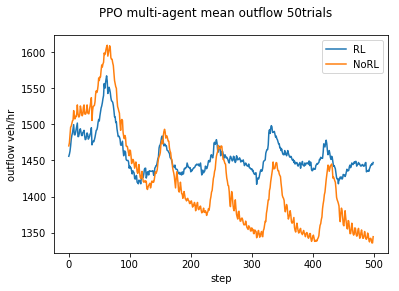

In [9]:
outflow_fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(outflow_mean)
ax.plot(human_outflow_mean)
title = AGENT + ' multi-agent mean outflow '+ str(num_trials) +'trials'
ax.set_ylabel('outflow veh/hr')
ax.set_xlabel('step')
ax.legend(['RL', 'NoRL'])
outflow_fig.suptitle(title)
#plt.subplots_adjust(top=0.8)

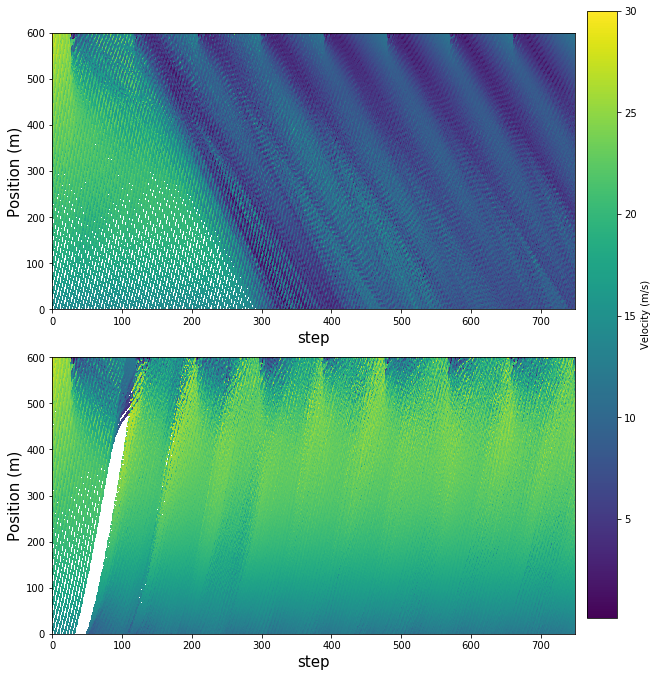

In [10]:
space_fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
space_fig.tight_layout(pad=3.0)

x = np.arange(int(env.env_params.horizon))
y = np.arange(0, int(left_length), step=0.1)
xx, yy = np.meshgrid(x, y)

# No RL
im = axes[0].pcolormesh(xx, yy, human_vel_map_mean.T)
axes[0].set_ylabel('Position (m)', fontsize=15.0)
axes[0].set_xlabel('step', fontsize=15.0)

# RL
im = axes[1].pcolormesh(xx, yy, vel_map_mean.T)
axes[1].set_ylabel('Position (m)', fontsize=15.0)
axes[1].set_xlabel('step', fontsize=15.0)

clb = space_fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
clb.set_clim(0, 30)
clb.set_label('Velocity (m/s)')
title = AGENT + ' Space-Time Diagram of 600 meter merge road'
# space_fig.suptitle(title)   
plt.subplots_adjust(top=0.9, right=0.8)

In [11]:
vel_filename = 'compare_trained_human_vel_'+str(num_trials)+'.png'
outflow_filename = 'compare_trained_human_outflow_'+str(num_trials)+'.png'
congestion_filename = 'compare_trained_human_congestion_'+str(num_trials)+'.png'
dir_path = '../result/MultiMerge/' + AGENT + '/' + exp_name + '/'+str(num_trials)+'/'
os.makedirs(dir_path, exist_ok=True)
vel_fig.savefig(dir_path + vel_filename)
outflow_fig.savefig(dir_path + outflow_filename)
space_fig.savefig(dir_path + congestion_filename)

NameError: name 'render' is not defined